In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'

In [41]:
import sys

In [42]:
caffe_root='/home/dagui/caffe-master/'
sys.path.insert(0,caffe_root+'python')
import caffe

In [43]:
import os

In [44]:
caffe.set_mode_cpu()
model_def=caffe_root+'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights=caffe_root+'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
net=caffe.Net(model_def,model_weights,caffe.TEST)

In [45]:
mu=np.load(caffe_root+'python/caffe/imagenet/ilsvrc_2012_mean.npy')

In [46]:
mu=mu.mean(1).mean(1)
print 'mean-subtracted values:',zip('BGR',mu)

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


In [47]:
transformer=caffe.io.Transformer({'data':net.blobs['data'].data.shape})
transformer.set_transpose('data',(2,0,1))
transformer.set_mean('data',mu)
transformer.set_raw_scale('data',255)
transformer.set_channel_swap('data',(2,1,0))

In [50]:
net.blobs['data'].reshape(50,3,227,227)

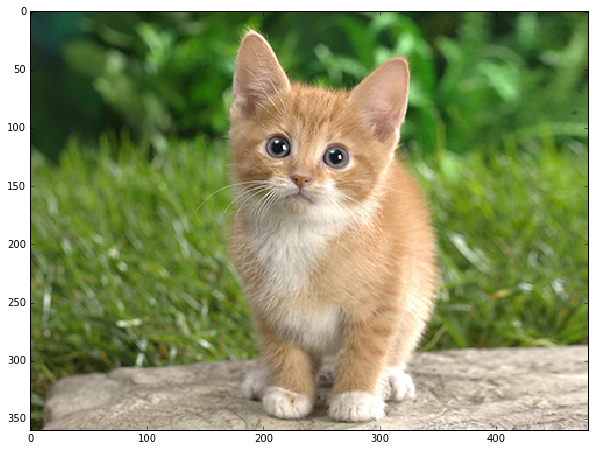

In [54]:
image=caffe.io.load_image(caffe_root+'examples/images/cat.jpg')
transformer_image=transformer.preprocess('data',image)
plt.imshow(image)

In [56]:
net.blobs['data'].data[...]=transformer_image
output=net.forward()
output_prob=output['prob'][0]
print 'predicted class is:',output_prob.argmax()

predicted class is: 281


In [58]:
labels_file=caffe_root+'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels=np.loadtxt(labels_file,str,delimiter='\t')
print 'output label:',labels[output_prob.argmax()]

output label: n02123045 tabby, tabby cat


In [70]:
top_inds=output_prob.argsort()[::-1][:5]
print 'probabilities and labels:'
zip(output_prob[top_inds],labels[top_inds])

probabilities and labels:


[(0.3124361, 'n02123045 tabby, tabby cat'),
 (0.23797214, 'n02123159 tiger cat'),
 (0.12387228, 'n02124075 Egyptian cat'),
 (0.10075711, 'n02119022 red fox, Vulpes vulpes'),
 (0.070956953, 'n02127052 lynx, catamount')]

In [71]:
%timeit net.forward()

1 loops, best of 3: 1.26 s per loop


In [72]:
caffe.set_device(0)
caffe.set_mode_gpu()
net.forward()
%timeit net.forward()

10 loops, best of 3: 49.7 ms per loop


In [74]:
[(k,v.data.shape) for k,v in net.blobs.items()]

[('data', (50, 3, 227, 227)),
 ('conv1', (50, 96, 55, 55)),
 ('pool1', (50, 96, 27, 27)),
 ('norm1', (50, 96, 27, 27)),
 ('conv2', (50, 256, 27, 27)),
 ('pool2', (50, 256, 13, 13)),
 ('norm2', (50, 256, 13, 13)),
 ('conv3', (50, 384, 13, 13)),
 ('conv4', (50, 384, 13, 13)),
 ('conv5', (50, 256, 13, 13)),
 ('pool5', (50, 256, 6, 6)),
 ('fc6', (50, 4096)),
 ('fc7', (50, 4096)),
 ('fc8', (50, 1000)),
 ('prob', (50, 1000))]

In [77]:
[(k,v[0].data.shape,v[1].data.shape) for k,v in net.params.iteritems()]

[('conv1', (96, 3, 11, 11), (96,)),
 ('conv2', (256, 48, 5, 5), (256,)),
 ('conv3', (384, 256, 3, 3), (384,)),
 ('conv4', (384, 192, 3, 3), (384,)),
 ('conv5', (256, 192, 3, 3), (256,)),
 ('fc6', (4096, 9216), (4096,)),
 ('fc7', (4096, 4096), (4096,)),
 ('fc8', (1000, 4096), (1000,))]

In [122]:
def vis_square(data):
    data=(data-data.min())/(data.max()-data.min())
    n=int(np.ceil(np.sqrt(data.shape[0])))
    padding=(((0,n**2-data.shape[0]),(0,1),(0,1))+((0,0),)*(data.ndim-3))
    data=np.pad(data,padding,mode='constant',constant_values=1)
    data=data.reshape((n,n)+data.shape[1:]).transpose((0,2,1,3)+tuple(range(4,data.ndim+1)))
    data=data.reshape((n*data.shape[1],n*data.shape[3])+data.shape[4:])
    plt.imshow(data);plt.axis('off')

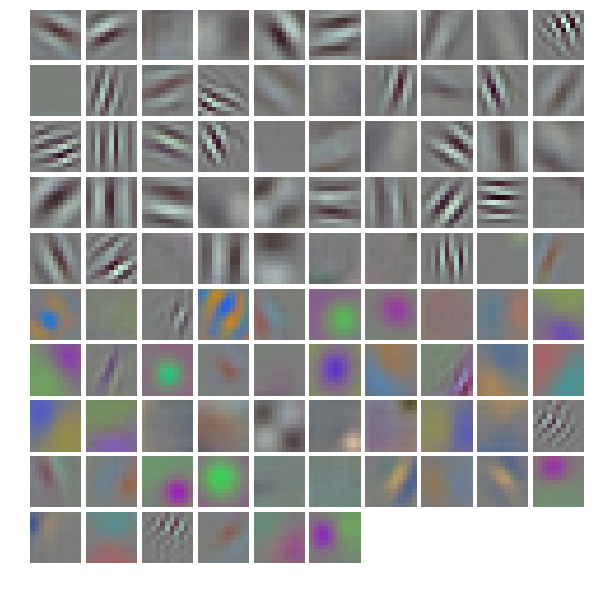

In [123]:
filters=net.params['conv1'][0].data
vis_square(filters.transpose(0,2,3,1))

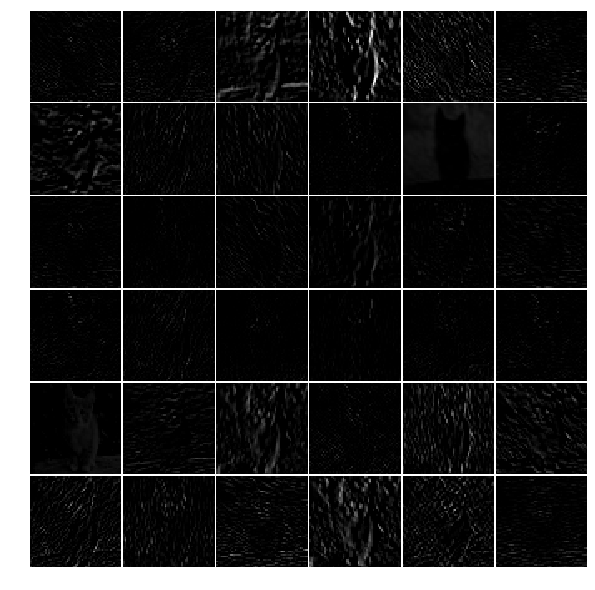

In [124]:
feat=net.blobs['conv1'].data[0,:36]
vis_square(feat)

In [125]:
feat=net.blobs['pool5'].data[0]

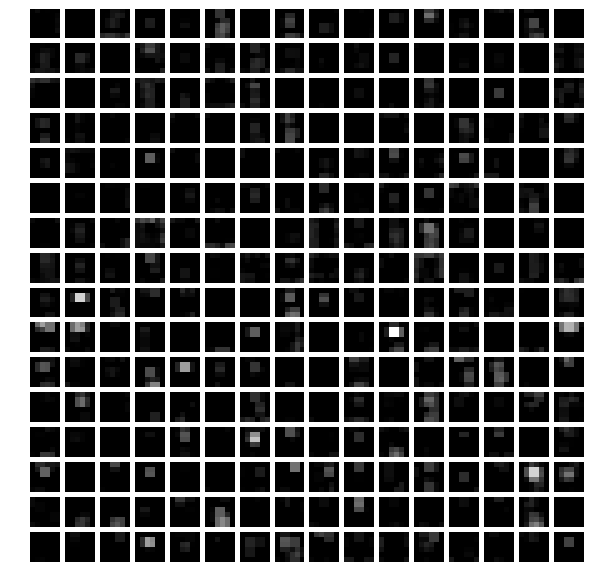

In [126]:
vis_square(feat)

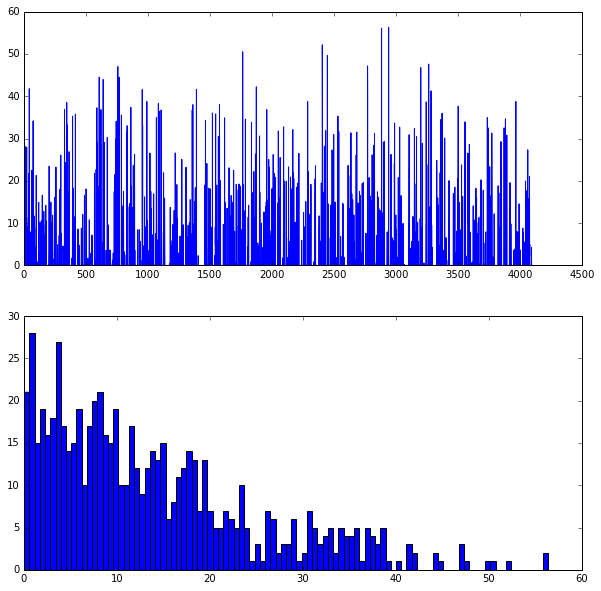

In [158]:
feat=net.blobs['fc6'].data[0]
plt.subplot(2,1,1)
plt.plot(feat.flat)
plt.subplot(2,1,2)
_=plt.hist(feat.flat[feat.flat>0],bins=100)
print feat.flat

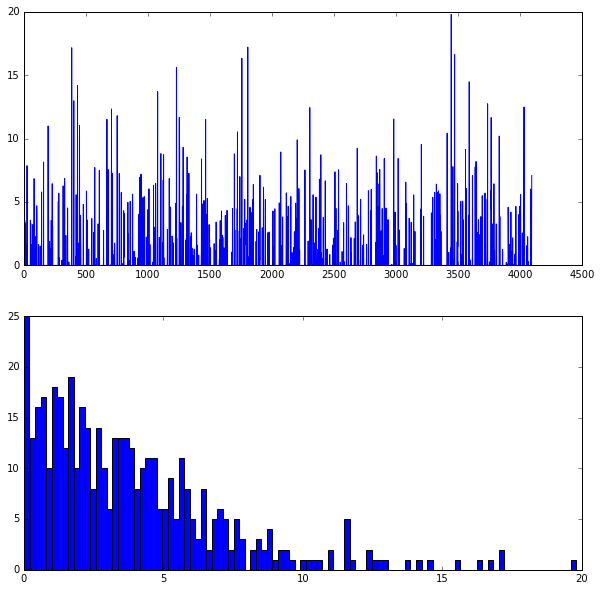

In [159]:
feat=net.blobs['fc7'].data[0]
plt.subplot(2,1,1)
plt.plot(feat.flat)
plt.subplot(2,1,2)
_=plt.hist(feat.flat[feat.flat>0],bins=100)
print feat.flat

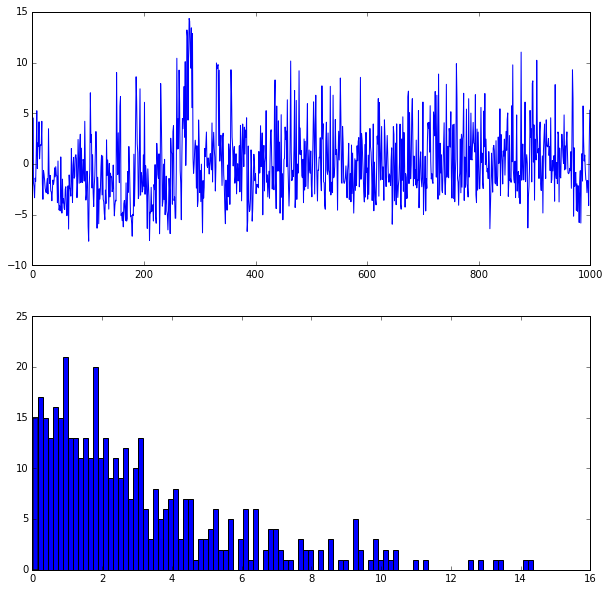

In [160]:
feat=net.blobs['fc8'].data[0]
plt.subplot(2,1,1)
plt.plot(feat.flat)
plt.subplot(2,1,2)
_=plt.hist(feat.flat[feat.flat>0],bins=100)
print feat.flat

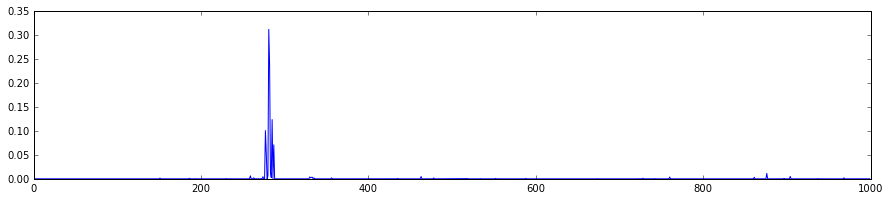

In [161]:
feat=net.blobs['prob'].data[0]
plt.figure(figsize=(15,3))
plt.plot(feat.flat)